# Random Forest Classifier

In [1]:
# Import dependencies for ML
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [2]:
# Import Dependencies for Database
from config import password
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
import psycopg2
import pandas as pd

/Users/juhiaggarwal/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
db_string = f"postgresql+psycopg2://postgres:" + password + "@127.0.0.1:5434/WineEnthusiast"

In [4]:
engine = create_engine(db_string)

In [5]:
inspector = inspect(engine)

In [6]:
inspector.get_table_names()

['wine', 'uswine', 'wineregions', 'winedata_ml']

In [7]:
connection = engine.connect

In [8]:
session = Session(engine)

In [9]:
engine.execute("SELECT * from uswine")

In [10]:
col_names_list = []

#i = 0
for i in range(len(inspector.get_columns('uswine'))):
    col_names_list.append(inspector.get_columns('uswine')[i]['name'])
    
for i in range(len(inspector.get_columns('wineregions'))):
    col_names_list.append(inspector.get_columns('wineregions')[i]['name'])
    
print(col_names_list)

['index', 'description', 'points', 'price', 'province', 'region', 'title', 'variety', 'winery', 'index', 'region', 'Latitude', 'Longitude']


In [11]:
US_wine_data_df = pd.DataFrame(columns = col_names_list)

In [12]:
# Inner join for wines and regions
import sys
join_db = engine.execute("SELECT * from uswine inner join wineregions on uswine.region = wineregions.region")
for record in join_db:
    record_series = pd.Series(list(record), index = US_wine_data_df.columns)
    
    US_wine_data_df = US_wine_data_df.append(record_series, ignore_index=True)
    #print(list(record))

In [18]:
US_wine_data_df.head()

,description,points,price,province,region,title,variety,winery,region,Latitude,Longitude
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris,Pinot Gris,Rainstorm,Willamette Valley,44.942554,-122.933762
1,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,44.942554,-122.933762
2,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,Napa Valley,38.502469,-122.265389
3,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Alexander Valley,Louis M. Martini 2012 Cabernet Sauvignon,Cabernet Sauvignon,Louis M. Martini,Alexander Valley,38.612965,-122.769435
4,Building on 150 years and six generations of w...,87,12.0,California,Central Coast,Mirassou 2012 Chardonnay,Chardonnay,Mirassou,Central Coast,29.703827,-95.571320


In [19]:
US_wine_data_df.columns

Index(['description', 'points', 'price', 'province', 'region', 'title',
       'variety', 'winery', 'region', 'Latitude', 'Longitude'],
      dtype='object')

In [21]:
US_wine_data_drop_df = US_wine_data_df.drop(columns = 'index', 'region', inplace=True)

SyntaxError: positional argument follows keyword argument (<ipython-input-21-1fcb1ce7909e>, line 1)

In [16]:
US_wine_data_df.head()

,description,points,price,province,region,title,variety,winery,region,Latitude,Longitude
0,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris,Pinot Gris,Rainstorm,Willamette Valley,44.942554,-122.933762
1,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Willamette Valley,44.942554,-122.933762
2,"Soft, supple plum envelopes an oaky structure ...",87,19.0,California,Napa Valley,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,Napa Valley,38.502469,-122.265389
3,"Slightly reduced, this wine offers a chalky, t...",87,34.0,California,Alexander Valley,Louis M. Martini 2012 Cabernet Sauvignon,Cabernet Sauvignon,Louis M. Martini,Alexander Valley,38.612965,-122.769435
4,Building on 150 years and six generations of w...,87,12.0,California,Central Coast,Mirassou 2012 Chardonnay,Chardonnay,Mirassou,Central Coast,29.703827,-95.571320


In [22]:
# joined data set with lat long and wine
US_wine_data_df.to_sql(name='uswine_db', con=engine, method='multi')

TypeError: execute_values() got an unexpected keyword argument 'fetch'

In [23]:
# # Cut this out
#Export data to csv
US_wine_data_df.to_csv("Data/US_Wine_Join.csv", index=False)

In [19]:
# Make a copy of the dataframe
US_wine_data_df_copy = US_wine_data_df
US_wine_data_df_copy.shape

(52668, 13)

## Pre process for machine learning

In [20]:
# Group wine price into bins.
price_counts = US_wine_data_df.price.value_counts()
price_counts

25.0     2773
20.0     2657
30.0     2502
35.0     2160
40.0     2083
         ... 
230.0       1
215.0       1
168.0       1
350.0       1
335.0       1
Name: price, Length: 160, dtype: int64

<AxesSubplot:ylabel='Density'>

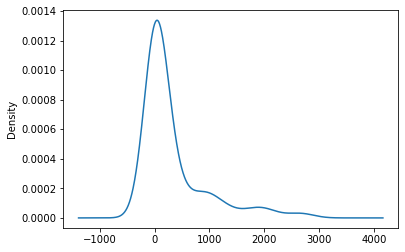

In [21]:
price_counts.plot.density()

In [22]:
# Create price bins
price_bins = [0, 15, 30, 60, 100, 500, 5000]
US_wine_data_df.groupby(pd.cut(US_wine_data_df["price"], price_bins)).count()

price_bins_names = ["<$15","$15-30","$30-60","$60-100", "100-500","too much"]

# Make a new column in dataframe for price bins.
US_wine_data_df["price_bins"] = pd.cut(US_wine_data_df["price"], price_bins, labels=price_bins_names)

# Check dataframe
US_wine_data_df.tail()

,description,points,price,province,region_1,region_2,title,variety,winery,region,Place_id,Latitude,Longitude,price_bins
52663,Hailing from one of the more popular vineyards...,90,20.0,California,Santa Ynez Valley,Central Coast,Birichino 2013 Jurassic Park Vineyard Old Vine...,Chenin Blanc,Birichino,Santa Ynez Valley,ChIJH3v79pZT6YAR-MXTvZmd134,34.584154,-120.097369,$15-30
52664,There's no bones about the use of oak in this ...,90,35.0,California,Napa Valley,Napa,Flora Springs 2013 Barrel Fermented Chardonnay...,Chardonnay,Flora Springs,Napa Valley,ChIJMU8qI_lPhIARfMUQoxvSFP4,38.502469,-122.265389,$30-60
52665,This opens with herbaceous dollops of thyme an...,90,35.0,California,Napa Valley,Napa,Hendry 2012 Blocks 7 & 22 Zinfandel (Napa Valley),Zinfandel,Hendry,Napa Valley,ChIJMU8qI_lPhIARfMUQoxvSFP4,38.502469,-122.265389,$30-60
52666,This Zinfandel from the eastern section of Nap...,90,22.0,California,Chiles Valley,Napa,Houdini 2011 Zinfandel (Chiles Valley),Zinfandel,Houdini,Chiles Valley,ChIJA5vomRzLRIYRd4u7z-L03go,30.345737,-97.773145,$15-30
52667,Citation is given as much as a decade of bottl...,90,75.0,Oregon,Oregon,Oregon Other,Citation 2004 Pinot Noir (Oregon),Pinot Noir,Citation,Oregon,ChIJVWqfm3xuk1QRdrgLettlTH0,43.804133,-120.554201,$60-100


In [23]:
# Create a DataFrame to hold columns ("description", "price", "province", "region_2", "title", "winery")
# that won't be used in machine learning in case we want them later.
US_wine_data_title_df = US_wine_data_df.drop(columns=["points", "region_1", "variety","price_bins"], axis=1)
print(US_wine_data_title_df.shape)
US_wine_data_title_df.head()

(52668, 10)


,description,price,province,region_2,title,winery,region,Place_id,Latitude,Longitude
0,"Tart and snappy, the flavors of lime flesh and...",14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Rainstorm,Willamette Valley,ChIJbezwJP6hlVQRBDL4exvIWSo,44.942554,-122.933762
1,"Pineapple rind, lemon pith and orange blossom ...",13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,St. Julian,Lake Michigan Shore,ChIJbWjISvi2EIgR-XXUbfv_U1k,42.220870,-86.369469
2,"Much like the regular bottling from 2012, this...",65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Sweet Cheeks,Willamette Valley,ChIJbezwJP6hlVQRBDL4exvIWSo,44.942554,-122.933762
3,"Soft, supple plum envelopes an oaky structure ...",19.0,California,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Kirkland Signature,Napa Valley,ChIJMU8qI_lPhIARfMUQoxvSFP4,38.502469,-122.265389
4,"Slightly reduced, this wine offers a chalky, t...",34.0,California,Sonoma,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Louis M. Martini,Alexander Valley,ChIJD2TljFMUhIARBOZe4vCoE7o,38.612965,-122.769435


In [24]:
# Export data with price bins
# Save cleaned columns ("description", "price", "province", "region_2", "title", "winery","latitude", "longitude")
US_wine_data_title_df.to_sql(name='winedata', con=engine)

In [25]:
# Save cleaned columns ("description", "price", "province", "region_2", "title", "winery")
# in case we want to load into database later.
US_wine_data_title_df.to_csv("Data/US_wine_data_title.csv", index=False)

In [85]:
# Create DataFrame for machine learning model. Drop: "description" - of flavors, i.e. tart and snappy, 
# oaky, etc., price, province, region_2, "title" - name on the bottle, winery.
# Dropped lat and long

US_wine_data_df_ml = US_wine_data_df.drop(columns=["description", "price", "region", "province", "region_2", "title", "winery", "Latitude", "Longitude", "Place_id"], axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(52668, 4)


,points,region_1,variety,price_bins
0,87,Willamette Valley,Pinot Gris,<$15
1,87,Lake Michigan Shore,Riesling,<$15
2,87,Willamette Valley,Pinot Noir,$60-100
3,87,Napa Valley,Cabernet Sauvignon,$15-30
4,87,Alexander Valley,Cabernet Sauvignon,$30-60


In [86]:
# Delete This 
#Save preprocessed dataframe (columns for machine learning: "points","region_1",""variety","price_bins")
US_wine_data_df_ml.to_csv("Data/US_wine_data_ml.csv", index=False)

In [88]:
# Export data for ML: (columns for machine learning: "points","region_1",""variety","price_bins")
US_wine_data_df_ml.to_sql(name='winedata_ml', con=engine)

### Checkpoint

In [89]:
# # Import data
# US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_ml.csv")
# print(US_wine_data_df_ml.shape)
# US_wine_data_df_ml.head()

In [90]:
# Look at unique values to see if categorical data requires binning
US_wine_data_df_ml.nunique()

points         21
region_1      247
variety       256
price_bins      6
dtype: int64

In [91]:
# Determine value_counts for binning
variety_counts = US_wine_data_df_ml.variety.value_counts()
variety_counts

Pinot Noir                        9847
Cabernet Sauvignon                7049
Chardonnay                        6674
Syrah                             3140
Red Blend                         2872
                                  ... 
Touriga Nacional Blend               1
Malvasia                             1
Cabernet Sauvignon-Tempranillo       1
Chardonnay-Riesling                  1
Riesling-Chardonnay                  1
Name: variety, Length: 256, dtype: int64

<AxesSubplot:ylabel='Density'>

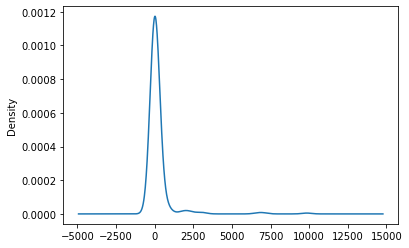

In [92]:
# Visualize the value counts of variety
variety_counts.plot.density()

In [93]:
# Determine which values to replace.  Per the plot, we tried <500 but after looking
# results we decided that we wanted to be more inclusive since some mainstream wines
# would be binned in "other".  Therefore we lowered the threshold for other to 300.
replace_variety = list(variety_counts[variety_counts <= 300].index)

# Replace in dataframe
for variety in replace_variety:
    US_wine_data_df_ml.variety = US_wine_data_df_ml.variety.replace(variety,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.variety.value_counts()

Pinot Noir                  9847
Cabernet Sauvignon          7049
Chardonnay                  6674
Other                       4435
Syrah                       3140
Red Blend                   2872
Merlot                      2245
Zinfandel                   2235
Sauvignon Blanc             2053
Bordeaux-style Red Blend    1791
Riesling                    1742
Cabernet Franc               961
Rosé                         874
Pinot Gris                   858
Viognier                     773
Sparkling Blend              674
Rhône-style Red Blend        671
Petite Sirah                 639
White Blend                  615
Malbec                       510
Grenache                     497
Sangiovese                   418
Gewürztraminer               403
Pinot Grigio                 358
Tempranillo                  334
Name: variety, dtype: int64

In [94]:
# Determine value_counts for binning
region_1_counts = US_wine_data_df_ml.region_1.value_counts()
region_1_counts

Napa Valley                           4475
Columbia Valley (WA)                  4109
Russian River Valley                  3090
California                            2629
Paso Robles                           2327
                                      ... 
Hawaii                                   1
Sonoma-Napa-Lake                         1
Sonoma County-Santa Barbara County       1
Ohio                                     1
California-Oregon                        1
Name: region_1, Length: 247, dtype: int64

<AxesSubplot:ylabel='Density'>

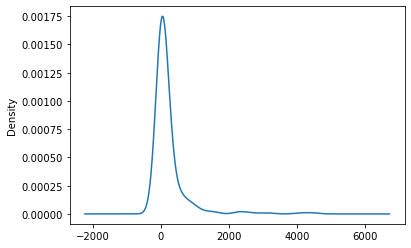

In [95]:
# Visualize the value counts of region_1
region_1_counts.plot.density()

In [96]:
# From the plot the curve breaks around 500.
replace_region_1 = list(region_1_counts[region_1_counts <= 300].index)

# Replace in dataframe
for region_1 in replace_region_1:
    US_wine_data_df_ml.region_1 = US_wine_data_df_ml.region_1.replace(region_1,"Other")
    
# Check to make sure binning was successful
US_wine_data_df_ml.region_1.value_counts()

Other                        9355
Napa Valley                  4475
Columbia Valley (WA)         4109
Russian River Valley         3090
California                   2629
Paso Robles                  2327
Willamette Valley            2296
Finger Lakes                 1556
Sonoma Coast                 1467
Sonoma County                1245
Walla Walla Valley (WA)      1061
Carneros                      999
Santa Barbara County          994
Yakima Valley                 984
Sta. Rita Hills               971
Santa Ynez Valley             806
Santa Lucia Highlands         802
Lodi                          799
Alexander Valley              780
Central Coast                 737
Red Mountain                  719
Santa Maria Valley            701
Sonoma Valley                 660
Anderson Valley               646
North Fork of Long Island     596
Horse Heaven Hills            554
Dundee Hills                  554
Virginia                      552
Santa Cruz Mountains          547
Oregon        

### Encode categorical data

In [97]:
# Create variable to hold categorical columns for OneHotEncoder
wine_cat = ["variety", "region_1"]

In [98]:
# from sklearn.preprocessing import OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(US_wine_data_df_ml[wine_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(wine_cat)
encode_df.shape
encode_df.head()

,variety_Bordeaux-style Red Blend,variety_Cabernet Franc,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Gewürztraminer,variety_Grenache,variety_Malbec,variety_Merlot,variety_Other,variety_Petite Sirah,...,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sonoma Valley,region_1_Sta. Rita Hills,region_1_Virginia,region_1_Wahluke Slope,region_1_Walla Walla Valley (WA),region_1_Washington,region_1_Willamette Valley,region_1_Yakima Valley
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
# Merge one-hot encoded features and drop the originals
US_wine_data_df_ml = US_wine_data_df_ml.merge(encode_df,left_index=True, right_index=True)
US_wine_data_df_ml = US_wine_data_df_ml.drop(wine_cat,axis=1)
print(US_wine_data_df_ml.shape)
US_wine_data_df_ml.head()

(52668, 71)


,points,price_bins,variety_Bordeaux-style Red Blend,variety_Cabernet Franc,variety_Cabernet Sauvignon,variety_Chardonnay,variety_Gewürztraminer,variety_Grenache,variety_Malbec,variety_Merlot,...,region_1_Sonoma Coast,region_1_Sonoma County,region_1_Sonoma Valley,region_1_Sta. Rita Hills,region_1_Virginia,region_1_Wahluke Slope,region_1_Walla Walla Valley (WA),region_1_Washington,region_1_Willamette Valley,region_1_Yakima Valley
0,87,<$15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,87,<$15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87,$60-100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,87,$15-30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,87,$30-60,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
# Save preprocessed dataframe to csv for future reference.
US_wine_data_df_ml.to_csv("Data/US_wine_data_enc.csv", index=False)

In [78]:
# # Import data
# US_wine_data_df_ml = pd.read_csv("Data/US_wine_data_enc.csv")

### Split preprocessed data 

In [101]:
# from sklearn.model_selection import train_test_split
# Split preprocessed data into our features and target arrays
#  Target
y = US_wine_data_df_ml["price_bins"].values
# Features
X = US_wine_data_df_ml.drop(["price_bins"],axis=1).values

In [102]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [103]:
# from sklearn.preprocessing import StandardScaler
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [104]:
print(X_train_scaled [0:5])

[[-0.18766944 -0.18314892 -0.137695   -0.39438636 -0.3798594  -0.08777402
  -0.09750392 -0.09750392 -0.20977538 -0.30366706 -0.11288172 -0.08418835
  -0.12843329 -0.48020733 -0.2396848  -0.11516011  5.35099601 -0.12944789
  -0.09094041 -0.20127874 -0.11242079 -0.25150619 -0.07900053 -0.12324325
  -0.1079487  -0.21069445 -0.12271292 -0.08937079 -0.11137706 -0.22898441
  -0.13779042 -0.12078562 -0.07932435  3.43331233 -0.09920947 -0.0883579
  -0.07802122 -0.1754013  -0.10329244 -0.12440248 -0.08218273 -0.08479618
  -0.08012831 -0.07900053 -0.30292057 -0.08202648 -0.1079487  -0.09248425
  -0.46348389 -0.2164614  -0.11661842 -0.08703883 -0.25144929 -0.08893806
  -0.13548328 -0.1012707  -0.12482151 -0.11661842 -0.12471687 -0.08821228
  -0.1692486  -0.15587582 -0.11379827 -0.13673746 -0.10316719 -0.08124082
  -0.14248582 -0.09065698 -0.21556268 -0.14025013]
 [-1.47071742 -0.18314892  7.26242777 -0.39438636 -0.3798594  -0.08777402
  -0.09750392 -0.09750392 -0.20977538 -0.30366706 -0.11288172 

## Machine Learning

### Try RandomForestClassifier

In [105]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
# Create a random forest classifier. 
rf_model = RandomForestClassifier(n_estimators=500, random_state=1) 

In [106]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [107]:
# Making predictions using the testing data.
y_pred = rf_model.predict(X_test_scaled)

In [108]:
# Display the confustion matrix
# from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3449, 1255,   38,    1,  439,    0],
       [1228, 3336,  225,   17,   58,    0],
       [  86,  728,  313,   43,    3,    0],
       [   3,   63,  123,   77,    0,    0],
       [ 760,   95,    2,    0,  823,    0],
       [   0,    1,    0,    1,    0,    0]], dtype=int64)

In [109]:
# Calculate the accuracy score
# from sklearn.metrics import accuracy_score, classification_report
acc_score = accuracy_score(y_test, y_pred)

In [110]:
# Displaying results
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, y_pred))

Accuracy Score : 0.607427660059239
Classification Report
              precision    recall  f1-score   support

      $15-30       0.62      0.67      0.64      5182
      $30-60       0.61      0.69      0.65      4864
     $60-100       0.45      0.27      0.33      1173
     100-500       0.55      0.29      0.38       266
        <$15       0.62      0.49      0.55      1680
    too much       0.00      0.00      0.00         2

    accuracy                           0.61     13167
   macro avg       0.48      0.40      0.43     13167
weighted avg       0.60      0.61      0.60     13167



C:\Users\rebek\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rebek\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rebek\anaconda3\envs\mlenv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
